In [1]:
import numpy as np
import pandas as pd
import os
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline

In [2]:
us_data_path = '/Users/ramtinyazdanian/Downloads/per_company_old/per company files/'
#sg_data_path = '/Users/ramtinyazdanian/Downloads/sg_it_skills_2018_2019_15days/'

us_sheet_map = {'Report1_Data': 'companies', 'Report2_Data': 'titles', 'Report3_Data': 'skill_clusters', 
                    'Report4_Data_specialized': 'specialised_skills', 'Report4_Data_baseline': 'baseline_skills',
                    'Report4_Data_software': 'programming_skills'}

# sg_sheet_map = {'Report1_Data': 'companies', 'Report2_Data': 'skill_clusters', 
#                     'Report3_Data_specialised': 'specialised_skills', 'Report3_Data_baseline': 'baseline_skills',
#                     'Report3_Data_software and progr': 'programming_skills'}

actual_sheet_map = us_sheet_map
root_data_path = us_data_path
all_filenames = os.listdir(root_data_path)
sheets_to_get = ['Filters']+list(actual_sheet_map.keys())

all_dataframes = [pd.read_excel(os.path.join(root_data_path,filename), sheet_name=sheets_to_get) 
                  for filename in all_filenames if filename[-4:] == 'xlsx' and filename[0] != '~']



In [3]:
time_period_index = -1
for i in range(all_dataframes[0]['Filters'].shape[0]):
    if all_dataframes[0]['Filters'].iloc[i][0] == 'Time Period:':
        time_period_index = i
        break

ad_count_index = -1
for i in range(all_dataframes[0]['Filters'].shape[0]):
    if all_dataframes[0]['Filters'].iloc[i][0] == 'Postings available with the current filters applied:':
        ad_count_index = i
        break
        
company_index = -1
for i in range(all_dataframes[0]['Filters'].shape[0]):
    if all_dataframes[0]['Filters'].iloc[i][0] == 'Employer with:':
        company_index = i
        break

all_dataframes_dict = {all_dataframes[i]['Filters'].iloc[company_index][1].strip('"') + '~' +
                       all_dataframes[i]['Filters'].iloc[time_period_index][1].strip('Custom range (').strip(') '):
                       {v:all_dataframes[i][k].drop(columns=
                                            [x for x in all_dataframes[i][k].columns.values if 'Unnamed:' in x]) 
                        for k,v in actual_sheet_map.items()}
                       for i in range(len(all_dataframes))}

ad_counts_dict = {all_dataframes[i]['Filters'].iloc[company_index][1].strip('"') + '~' + 
                  all_dataframes[i]['Filters'].iloc[time_period_index][1].strip('Custom range (').strip(') '): 
                  all_dataframes[i]['Filters'].iloc[ad_count_index][1] for i in range(len(all_dataframes))}

In [4]:
def get_concatenated_df_with_dates(df_dict, sheet_name, normalising_dict=None, use_log=False):
    if normalising_dict is None:
        return pd.concat([df_dict[k][sheet_name].assign(Company = k.split('~')[0]).assign(Date = 
                                   datetime.strptime(k.split('~')[1].split('-')[0].strip(), '%b. %d, %Y')) 
                                   for k in df_dict]).reset_index().drop(columns='index')
    else:
        result = pd.concat([df_dict[k][sheet_name].assign(Company = k.split('~')[0]).assign(Date = 
                                   datetime.strptime(k.split('~')[1].split('-')[0].strip(), '%b. %d, %Y')).
                                   assign(Total = normalising_dict[k])
                                   for k in df_dict]).reset_index().drop(columns='index')
        result['Job Postings Raw'] = result['Job Postings']
        if use_log:
            result['Job Postings'] = result['Job Postings'].apply(np.log)/result['Total'].apply(np.log)
        else:
            result['Job Postings'] = result['Job Postings']/result['Total']
        return result

In [5]:
def delete_low_freq_skills(df, min_freq):  
    skill_counts = df.groupby('Skill').count().reset_index()
    low_count_skills = skill_counts.loc[skill_counts['Job Postings'] < min_freq].Skill.values
    return df.loc[df.Skill.apply(lambda x: x not in low_count_skills)]
    
def get_period_of_time(df, start, end):
    return df.loc[(df.Date >= start) & (df.Date < end)]

def fill_in_the_blank_dates(df, method='min', has_company=True):
    columns_list = ['Job Postings', 'Job Postings Raw', 'Total']
    if has_company:
        base_cols = ['Date', 'Company']
    else:
        base_cols = ['Date']
    filling_df = df[base_cols+columns_list].groupby(base_cols)
    if method == 'min':
        filling_df = filling_df.min()
    elif method == 'mean':
        filling_df = filling_df.mean()
    elif method == 'median':
        filling_df = filling_df.median()
    elif method == 'zero':
        filling_df = filling_df.min()
        for col in columns_list:
            if col != 'Total':
                filling_df[col] = 0
    else:
        return df
    filling_df = filling_df.reset_index().assign(key_col=1)
    skills_only_df = df[['Skill']].drop_duplicates().assign(key_col=1)
    print('Number of skills: '+str(skills_only_df.shape[0]))
    filling_df = pd.merge(filling_df, skills_only_df, on='key_col').drop(columns=['key_col'])
    result_df = pd.merge(df, filling_df, how='right', on=['Skill']+base_cols, 
                         suffixes=('_actual', '_filled'))
    
    for col in columns_list:
        result_df[col+'_filled'] = result_df.apply(lambda x: x[col+'_filled'] if pd.isnull(x[col+'_actual']) else 
                                                  x[col+'_actual'], axis=1)
    result_df = result_df.drop(columns = [x+'_actual' for x in columns_list]).rename(
                                    columns={x+'_filled':x for x in columns_list})
    return result_df

def group_time_steps_together(df, steps_to_group=3, has_company=True):
    if steps_to_group == 1:
        return df
    if has_company:
        base_cols = ['Date', 'Company']
    else:
        base_cols = ['Date']
    dates_df = df[base_cols].drop_duplicates().sort_values(base_cols).reset_index().drop(columns=['index'])
    dates_df['group'] = pd.Series(list(range(dates_df.shape[0])))
    dates_df['group'] = dates_df['group'].apply(lambda x: 1 + (x//steps_to_group))
    print(dates_df)
    min_dates = dates_df.groupby('group').min().reset_index()
    result_df = pd.merge(df, dates_df, on=base_cols).drop(columns=['Date']).groupby(['group', 'Skill']).mean().\
                                    reset_index()
    result_df = pd.merge(result_df, min_dates, on='group').drop(columns=['group'])
    return result_df

In [6]:
def linreg_jobpostings(df, y_col='Job Postings', normaliser=None):
    if normaliser is None:
        y = PolynomialFeatures(degree=2, include_bias=False).fit_transform(df[['Job Postings']].values)
    else:
        y = PolynomialFeatures(degree=2, include_bias=False).fit_transform(df[['Job Postings']].values - 
                                                                           normaliser[['Total']].values)
    X = df[['Date']].values
    X = (X - X.min()).astype('timedelta64[D]') / np.timedelta64(1, 'D') / 30
    result_model = LinearRegression()
    result_model.fit(X, y) # Weighting the first point makes no conceptual sense because the 1st point isn't special.
    spike_value = y.max() / y.mean()
    return result_model.coef_[0][0], result_model.coef_[1][0], spike_value, result_model.intercept_[0]

In [7]:
def get_trend_slope_intercept(group_col_and_trends):
    group_col_and_trends['Slope'] = group_col_and_trends[0].apply(lambda x: x[0] if not 
                                                                               pd.isna(x) else np.nan)
    group_col_and_trends['Intercept'] = group_col_and_trends[0].apply(lambda x: x[3] if not 
                                                                               pd.isna(x) else np.nan)
    group_col_and_trends['Acceleration'] = group_col_and_trends[0].apply(lambda x: x[1] if not 
                                                                               pd.isna(x) else np.nan)
    group_col_and_trends['Spikiness'] = group_col_and_trends[0].apply(lambda x: x[2] if not 
                                                                               pd.isna(x) else np.nan)
    group_col_and_trends = group_col_and_trends.drop(columns=0)
    return group_col_and_trends

In [8]:
def get_set_of_companies(df, companies):
    return df.loc[df.Company.apply(lambda x: x in companies)].copy()

In [9]:
def compute_total_log_mean(df):
    """
    For each date, computes the average, among all companies, of the log of their total number of ads.
    """
    return df[['Date', 'Company', 'Total']].drop_duplicates().drop(columns=['Company'])\
                    .groupby('Date').apply(lambda x: np.mean(x['Total'].apply(np.log))).reset_index().rename(
                                                            columns={0: 'Total'})

def compute_total_values(df):
    return df[['Date', 'Company', 'Total']].drop_duplicates().groupby('Date').\
                                                                sum().reset_index()

def logsum_trend_slope_wrapper(df, starting_date, end_date, total_log, min_freq=1, grouping=1, nafill='zero'):
    """
    Computes the dataframe containing the log sum trends (slope, intercept, acceleration, etc.) based on 
    a skills dataframe. The starting dataframe needs to have the columns 'Date', 'Skill', and 
    'Job Postings Raw', and needs to be company-level. The log of the company-level values is taken, 
    and then they are summed up, grouped by skill and date.
    """
    print('Start: ' + str(starting_date))
    print('End: ' + str(end_date))
    df = get_period_of_time(df, starting_date, end_date).copy()
    skills_raw_sums = df[['Skill', 'Job Postings Raw']].groupby('Skill').sum()
    df['Job Postings'] = df['Job Postings Raw'].apply(lambda x: np.log(1+x))
    df = df.groupby(['Date', 'Skill']).sum().reset_index()

    df_with_trends_pooled = pd.DataFrame(
        fill_in_the_blank_dates(
            group_time_steps_together(
                delete_low_freq_skills(df, min_freq), 
                            steps_to_group=grouping, has_company=False), method=nafill, has_company=False).
                                 groupby('Skill').apply(lambda x: 
                                    linreg_jobpostings(x, normaliser=
                                           get_period_of_time(total_log, starting_date, 
                                                              end_date))))
    df_with_trends_pooled = get_trend_slope_intercept(df_with_trends_pooled)
    print(df_with_trends_pooled.sort_values('Slope', ascending=False).describe())
    return df_with_trends_pooled.join(skills_raw_sums)

def threshold_logsum_trends_simple(df_with_trends, total, slope_percentile_thresh = 0.95, 
                                   slope_thresh = None, pop_lower=0.001, pop_upper=0.01):
    pop_lower = pop_lower*total
    pop_upper = pop_upper*total
    if slope_percentile_thresh is not None:
        slope_thresh = df_with_trends.Slope.quantile(slope_percentile_thresh)
    return df_with_trends.loc[(df_with_trends['Slope'] >= np.log(1+slope_thresh)) & 
                              (df_with_trends['Job Postings Raw'] >= pop_lower) &
                              (df_with_trends['Job Postings Raw'] < pop_upper)].reset_index()

In [10]:
def compute_prec_recall(predicted_set, reference_set):
    predicted_set = predicted_set.Skill.values
    reference_set = reference_set.Skill.values
    accurately_predicted = set(reference_set).intersection(set(predicted_set))
    print(accurately_predicted)
    print(len(accurately_predicted), len(predicted_set), len(reference_set))
    if len(predicted_set) > 0:
        prec = len(accurately_predicted) / len(predicted_set)
        recall = len(accurately_predicted) / len(reference_set)
        f1 = 2*prec*recall / (prec+recall)
    else:
        prec = 0
        recall = 0
        f1 = 0
    return prec, recall, f1

In [11]:
skill_clusters_df = get_concatenated_df_with_dates(all_dataframes_dict, 
                                   'skill_clusters', normalising_dict=ad_counts_dict).\
                                   sort_values(['Company', 'Date', 'Job Postings'], ascending=[True, True, False]).\
                                   reset_index().drop(columns='index')
skills_df = get_concatenated_df_with_dates(all_dataframes_dict, 
                                   'specialised_skills', normalising_dict=ad_counts_dict, use_log=False).\
                                   sort_values(['Company', 'Date', 'Job Postings'], ascending=[True, True, False]).\
                                   reset_index().drop(columns='index')
prog_skills_df = get_concatenated_df_with_dates(all_dataframes_dict, 
                                   'programming_skills', normalising_dict=ad_counts_dict, use_log=False).\
                                   sort_values(['Company', 'Date', 'Job Postings'], ascending=[True, True, False]).\
                                   reset_index().drop(columns='index')

In [12]:
quarterly_totals = compute_total_values(skill_clusters_df)
quarterly_totals

,Date,Total
0,2018-01-01,39837
1,2018-04-01,40739
2,2018-07-01,49138
3,2018-10-01,44802
4,2019-01-01,28256
5,2019-04-01,27372
6,2019-07-01,27014
7,2019-10-01,30174


In [13]:
total_log = compute_total_log_mean(skill_clusters_df)
total_log

,Date,Total
0,2018-01-01,6.189489
1,2018-04-01,6.240892
2,2018-07-01,6.567636
3,2018-10-01,6.494223
4,2019-01-01,6.249406
5,2019-04-01,6.221829
6,2019-07-01,6.202909
7,2019-10-01,6.312023


In [14]:
start_and_end_dates = [(np.datetime64('2018-01-01'), np.datetime64('2019-01-01')), 
                       (np.datetime64('2019-01-01'), np.datetime64('2020-01-01')),
                       (np.datetime64('2018-01-01'), np.datetime64('2020-01-01'))]
total_values = [get_period_of_time(quarterly_totals, start_and_end_dates[i][0], start_and_end_dates[i][1]).sum()[0]
                for i in range(len(start_and_end_dates))]
n_years = [1,1,2]

In [15]:
total_values

[174516, 112816, 287332]

In [16]:
print('Skill Clusters')
skill_cluster_trends = [logsum_trend_slope_wrapper(skill_clusters_df.rename(columns={'Skill Cluster': 'Skill'}), 
                                                  start_and_end_dates[i][0], start_and_end_dates[i][1],
                                                  total_log) for i in range(len(start_and_end_dates))]

print('Specialised Skills')
specialised_skill_trends = [logsum_trend_slope_wrapper(skills_df, 
                                                  start_and_end_dates[i][0], start_and_end_dates[i][1],
                                                  total_log) for i in range(len(start_and_end_dates))]

print('Programming Skills')
programming_skill_trends = [logsum_trend_slope_wrapper(prog_skills_df, 
                                                  start_and_end_dates[i][0], start_and_end_dates[i][1],
                                                  total_log) for i in range(len(start_and_end_dates))]

Skill Clusters
Start: 2018-01-01
End: 2019-01-01
Number of skills: 507
            Slope   Intercept  Acceleration    Spikiness
count  507.000000  507.000000    507.000000   507.000000
mean     0.517729   31.103121     98.311838     0.987188
std      0.859419   48.242858    184.989388    51.780073
min     -1.798717   -6.930406    -84.422388 -1161.728105
25%     -0.074127   -3.948659     -0.154561     2.385519
50%      0.248135    8.131024      2.380011     2.800393
75%      1.151364   51.833544    107.426002     3.628929
max      6.565614  204.646683   1385.063785    18.054322
Start: 2019-01-01
End: 2020-01-01
Number of skills: 510
            Slope   Intercept  Acceleration   Spikiness
count  510.000000  510.000000    510.000000  510.000000
mean     0.036919   31.609617      6.415015    3.284995
std      0.473304   49.238540     60.797804    1.688440
min     -3.054977   -6.992118   -613.365526    1.996046
25%     -0.184938   -4.182258     -2.340785    2.227692
50%      0.012117    6.6

In [17]:
specialised_skill_trends[0].Slope.quantile(0.8)

0.39181906077312306

Notice how the slopes for 2018 are consistently higher than for 2019 (and therefore also for 2018-2020).

Now, having seen the summary statistics, let's see the correlations of these metrics for some of the skill trend dataframes. First, 2018-2020:

In [18]:
specialised_skill_trends[2].corr(method='pearson')

,Slope,Intercept,Acceleration,Spikiness,Job Postings Raw
Slope,1.000000,-0.159437,0.721127,0.019532,-0.064566
Intercept,-0.159437,1.000000,-0.217107,-0.166621,0.821042
Acceleration,0.721127,-0.217107,1.000000,0.034315,-0.159388
Spikiness,0.019532,-0.166621,0.034315,1.000000,-0.138762
Job Postings Raw,-0.064566,0.821042,-0.159388,-0.138762,1.000000


In [19]:
specialised_skill_trends[2].corr(method='spearman')

,Slope,Intercept,Acceleration,Spikiness,Job Postings Raw
Slope,1.000000,-0.325342,0.033289,-0.018336,-0.114721
Intercept,-0.325342,1.000000,0.151096,0.339438,0.916672
Acceleration,0.033289,0.151096,1.000000,0.061542,-0.028310
Spikiness,-0.018336,0.339438,0.061542,1.000000,0.412025
Job Postings Raw,-0.114721,0.916672,-0.028310,0.412025,1.000000


Quite interestingly, Slope values are highly correlated with Acceleration values when we use Pearson, but with Spearman, they are entirely uncorrelated. This means that even though intuitively, faster growth and greater acceleration are correlated, when it comes to ranking the skills by these two values, the rankings have nothing to do with each other. Since what we primarily care about is growth (and we'd only want to give accelerating growth a higher score than constant or decelerating growth), I think this shows that thresholding on the Slope is better, and the Acceleration values could then be used to rank those. On the other hand, if we had reliable ground truth for emerging skills, this lack of correlation would mean that these would work together pretty well in a predictive model that would compute the optimal weights for each of the metrics.

As we expected, Acceleration and Spikiness are not correlated in any way.

In [20]:
emerging_spec_skills = [threshold_logsum_trends_simple(specialised_skill_trends[i], total=total_values[i]) 
                        for i in range(len(specialised_skill_trends))]
emerging_prog_skills = [threshold_logsum_trends_simple(programming_skill_trends[i], total=total_values[i]) 
                        for i in range(len(programming_skill_trends))]

In [21]:
def compare_emerging_skill_sets(emerging_skills, dates):
    for i in range(len(emerging_skills)):
        for j in range(i+1,len(emerging_skills)):
            print('\nComparing ' + ' to '.join([str(dates[i][k]) for k in range(2)]) + ' with ' + 
                                            ' to '.join([str(dates[j][k]) for k in range(2)]))
            skills_shared = set(emerging_skills[i].Skill.values).intersection(set(emerging_skills[j].Skill.values))
            skills_exclusive_i = \
                        set(emerging_skills[i].Skill.values).difference(set(emerging_skills[j].Skill.values))
            skills_exclusive_j = \
                        set(emerging_skills[j].Skill.values).difference(set(emerging_skills[i].Skill.values))
            print('\n# of skills shared and exclusive to each date (in order)')
            print(len(skills_shared), len(skills_exclusive_i), len(skills_exclusive_j))
            print('\nThe skills themselves:')
            print('\nShared:' + '\n')
            print(skills_shared)
            print('\nExclusive to '+ ' to '.join([str(dates[i][k]) for k in range(2)]) + '\n')
            print(skills_exclusive_i)
            print('\nExclusive to '+ ' to '.join([str(dates[j][k]) for k in range(2)]) + '\n')
            print(skills_exclusive_j)

Let's compare the emerging skill sets for the specialised skills, comparing all three periods (2018, 2019, and combined).

In [22]:
compare_emerging_skill_sets(emerging_spec_skills, start_and_end_dates)


Comparing 2018-01-01 to 2019-01-01 with 2019-01-01 to 2020-01-01

# of skills shared and exclusive to each date (in order)
26 126 132

The skills themselves:

Shared:

{'Customer Billing', 'Vendor Relations', 'Cabling', 'Hardware Support', 'TIBCO', 'SAP HANA', 'Model-View-Controller (MVC)', 'SAP Netweaver', 'Microservice', 'Online Analytical Processing (OLAP)', 'AWS CloudFormation', 'OpenShift', 'Risk and Mitigation Analysis', 'Customer Checkout', 'Database Upgrade', 'Business-to-Business', 'Oauth', 'Secure Shell', 'Contract Review', 'Data Engineering', 'SAP CRM', 'Business Intelligence Reporting', 'SAP BusinessObjects', 'Bitbucket', 'Six Sigma', 'Negotiation Skills'}

Exclusive to 2018-01-01 to 2019-01-01

{'TypeScript', 'Object-Oriented Programming', 'Strategic Partnerships', 'Adobe Creative Suite', 'Mulesoft', 'Cloud Foundry', 'Product Design', 'Software Quality Assurance', 'Activex Data Object (ADO)', 'Teaching', 'System Maintenance', 'Spring Boot', 'Data Validation', 'Front-end D

Let's compare the emerging skill sets for the programming skills, comparing all three periods (2018, 2019, and combined).

In [23]:
compare_emerging_skill_sets(emerging_prog_skills, start_and_end_dates)


Comparing 2018-01-01 to 2019-01-01 with 2019-01-01 to 2020-01-01

# of skills shared and exclusive to each date (in order)
10 66 46

The skills themselves:

Shared:

{'Hyper-V', 'AWS CloudFormation', 'Jenkins', 'OpenShift', 'Apex Code', 'AWS Elastic Compute Cloud (EC2)', 'SAP HANA', 'SAP BusinessObjects', 'Salesforce Lightning', 'Golang (Go Programming Language)'}

Exclusive to 2018-01-01 to 2019-01-01

{'Object-Oriented Programming', 'Spring Web Services', 'Apache Spark', 'Adobe Creative Suite', 'Apache Impala', 'Object Oriented Development Software', 'Nginx', 'Software Quality Assurance', 'VMware Horizon View', 'Activex Data Object (ADO)', 'Delphi', 'Software Analysis', 'User Acceptance Testing (UAT)', 'TestNG', 'Advanced Business Application Programming (ABAP)', 'Metasploit', 'Datastage', 'Confluence', 'Model-View-Controller (MVC)', 'Spring Boot', 'COBOL', 'Jetty (Web Server)', 'VMware vSphere', 'Adobe Acrobat', 'ASP.NET MVC', 'Veritas NetBackup', 'VBScript', 'VMware ESXi', 'SQL Se

The 2018-2020 skills are far less numerous and also generally look more legit (well if we exclude "Visual Basic").

## Emerged skills
Now let's look at the skills that are in a higher popularity bracket.

In [24]:
above_emerging_spec_skills = [threshold_logsum_trends_simple(specialised_skill_trends[i], 
                         total = total_values[i], pop_lower=0.01, pop_upper=0.05) 
                        for i in range(len(specialised_skill_trends))]
above_emerging_prog_skills = [threshold_logsum_trends_simple(programming_skill_trends[i], 
                         total = total_values[i], pop_lower=0.01, pop_upper=0.05)
                        for i in range(len(programming_skill_trends))]

In [25]:
compare_emerging_skill_sets(above_emerging_spec_skills, start_and_end_dates)


Comparing 2018-01-01 to 2019-01-01 with 2019-01-01 to 2020-01-01

# of skills shared and exclusive to each date (in order)
24 112 33

The skills themselves:

Shared:

{'Application Design', 'Eclipse', 'Artificial Intelligence', 'Docker Software', 'Microsoft Active Directory', 'Prototyping', 'Data Security', 'Systems Development Life Cycle (SDLC)', 'Requirements elicitation', 'Ansible', 'Kubernetes', 'Node.js', 'Microsoft PowerShell', 'Hardware and Software Configuration', 'Teradata DBA', 'Data Architecture', 'Tableau', 'PostgreSQL', 'Atlassian JIRA', 'Client/Server', 'Data Science', 'Procurement', 'Data Migration', 'Business Solutions'}

Exclusive to 2018-01-01 to 2019-01-01

{'Simulation', 'Requirements Verification and Validation', 'Machine Learning', 'Continuous Integration (CI)', 'Information Assurance', 'Windows Server', 'Salesforce', 'User Interface (UI) Design', 'AngularJS', 'Software Architecture', 'Systems Analysis', 'Network Security', 'Description and Demonstration of Produ

This has Data Science, NLP, etc. so this is a very reasonable and self-validating sort of set, as opposed to the "emerging" skills which are lower in popularity and often more obscure.

In [26]:
compare_emerging_skill_sets(above_emerging_prog_skills, start_and_end_dates)


Comparing 2018-01-01 to 2019-01-01 with 2019-01-01 to 2020-01-01

# of skills shared and exclusive to each date (in order)
16 52 9

The skills themselves:

Shared:

{'Microsoft PowerShell', 'Application Design', 'Apache Kafka', 'Docker Software', 'Software as a Service (SaaS)', 'React Javascript', 'Teradata DBA', 'Systems Development Life Cycle (SDLC)', 'Tableau', 'Amazon Web Services (AWS)', 'Atlassian JIRA', 'Ansible', 'PostgreSQL', 'Solution Architecture', 'JavaScript Object Notation (JSON)', 'Node.js'}

Exclusive to 2018-01-01 to 2019-01-01

{'Informatica', 'Data Visualization', 'Eclipse', 'Red Hat Linux', 'Apache Webserver', 'jQuery', 'Virtual Private Networking (VPN)', 'Salesforce', 'UNIX Shell', 'Windows Server', 'Microsoft Windows', 'AngularJS', 'IBM WEBSPHERE', 'Adobe Photoshop', 'Agile Development', 'Systems Analysis', 'Microsoft Project', 'Object-Oriented Analysis and Design (OOAD)', 'Platform as a Service (PaaS)', 'Computer Engineering', 'Extensible Markup Language (XML)',

Now let's try out our method for a few companies, see how it works:

In [27]:
skills_df.Company.unique()

array(['Adobe Systems', 'Allscripts', 'Apple Inc.',
       'Avanade Incorporated', 'CACI', 'CGI Group', 'Cdw Corporation',
       'Ciber Incorporated', 'Computer Aid Incorporated',
       'Data Incorporated', 'Ellucian', 'FIS', 'Facebook', 'Fiserv',
       'Google Inc.', 'HCL America', 'Inficare Technologies', 'Infosys',
       'Intuit', 'Jack Henry & Associates', 'MITRE Corporation',
       'Mantech International Corp.', 'Microsoft Corporation',
       'NCR Corporation', 'NTT Data', 'Nityo Infotech', 'Oracle',
       'Perficient Incorporated', 'SAP', 'Salesforce',
       'Sirius Computer Solutions', 'TATA Consultancy Services', 'Unisys',
       'VLS Systems', 'Vdart, Inc', 'Viva USA', 'Vmware Incorporated',
       'Wipro', 'Workday, Inc', 'Xoriant Incorporated'], dtype=object)

In [28]:
set_of_companies = ['Facebook', 'Google Inc.', 'Microsoft Corporation', 'Apple Inc.']
companies_skills = get_set_of_companies(skills_df, set_of_companies)
companies_specialised_skill_trends = [logsum_trend_slope_wrapper(companies_skills, 
                                                  start_and_end_dates[i][0], start_and_end_dates[i][1],
                                                  compute_total_log_mean(
                                              companies_skills)) 
                                      for i in range(len(start_and_end_dates))]

Start: 2018-01-01
End: 2019-01-01
Number of skills: 1398
             Slope    Intercept  Acceleration    Spikiness
count  1398.000000  1398.000000   1398.000000  1398.000000
mean      0.046649    -3.331494      0.365439     4.088359
std       0.243655     4.168391      2.371811     6.287097
min      -0.710088    -8.356725     -6.753065   -85.334298
25%      -0.117194    -6.143582     -0.675390     2.905416
50%       0.028322    -4.747029      0.190241     3.306473
75%       0.217202    -1.894252      1.856462     4.399859
max       2.286112    16.774717      8.781386   197.464137
Start: 2019-01-01
End: 2020-01-01
Number of skills: 1472
             Slope    Intercept  Acceleration    Spikiness
count  1472.000000  1472.000000   1472.000000  1472.000000
mean      0.001684    -3.480091     -0.087738     3.706426
std       0.183604     4.041329      1.525305     2.275352
min      -1.294457    -7.898365     -5.561899   -16.345711
25%      -0.107642    -6.295645     -0.998783     2.671171
5

In [29]:
companies_emerging_spec_skills = [threshold_logsum_trends_simple(
        companies_specialised_skill_trends[i],
    total=get_period_of_time(compute_total_values(companies_skills),
                                                    start_and_end_dates[i][0], start_and_end_dates[i][1]).sum()[0])
                        for i in range(len(companies_specialised_skill_trends))]

In [30]:
[compute_prec_recall(companies_emerging_spec_skills[i], emerging_spec_skills[i]) 
                     for i in range(len(companies_emerging_spec_skills))]

{'Strategic Partnerships', 'Cloud Foundry', 'SAP HANA', 'Business Requirements Documentation', 'SAP Netweaver', 'Online Analytical Processing (OLAP)', 'Jetty (Web Server)', 'OpenShift', 'TOGAF', 'Enterprise Software', 'Oauth', 'Psychology', 'API Management', 'CentOS', 'Data Encryption', 'Linux Scripting', 'Case Management', 'PCI DSS', 'Go-to-market Strategy'}
19 81 152
{'Teradata', 'Capacity Management', 'Business Management', 'Packaging', 'Construction Management', 'Strategic Planning', 'AWS Redshift', 'Azure Security', 'Risk and Mitigation Analysis', 'Needs Assessment', 'Cost Control', 'Graphic Design', 'Qlik', 'Service Improvement'}
14 75 158
{'Scenario testing', 'Microservice', 'API Management', 'Reliability Engineering Studies', 'Cluster Analysis', 'Business-to-Business', 'Sales Strategy', 'Prospective Clients', 'Threat Intelligence and Analysis', 'Hardware Support', 'Enterprise Sales'}
11 70 141


[(0.2345679012345679, 0.125, 0.1630901287553648),
 (0.18666666666666668, 0.08860759493670886, 0.12017167381974249),
 (0.15714285714285714, 0.07801418439716312, 0.10426540284360189)]

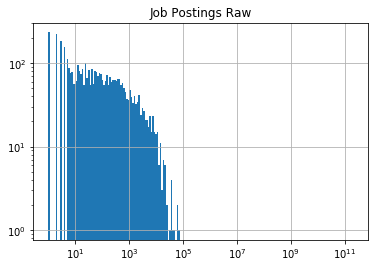

In [73]:
skills_df[['Skill', 'Job Postings Raw']].groupby('Skill').sum().\
                        hist(bins = np.logspace(np.log(1), np.log(80000), 200))
plt.yscale('log')
plt.xscale('log')

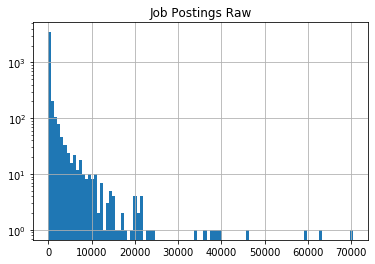

In [32]:
skills_df[['Skill', 'Job Postings Raw']].groupby('Skill').sum().\
                        hist(bins = 100)
plt.yscale('log')

In [65]:
skills_df[['Skill', 'Job Postings Raw']].groupby('Skill').sum().describe()

,Job Postings Raw
count,4130.000000
mean,799.968523
std,3173.388790
min,1.000000
25%,7.000000
50%,41.000000
75%,309.500000
max,70347.000000


In [34]:
skills_df[['Skill', 'Job Postings Raw']].groupby('Skill').sum()

,Job Postings Raw
Skill,
.NET,15394
21 CFR Part 11,11
3D Animation,378
3D Modeling / Design,35
3D Printing / Additive Manufacturing (AM),8
...,...
trigonometry,11
uPerform,8
virtual sales,10


In [230]:
(specialised_skill_trends[0].Slope > 2.5).sum()

16

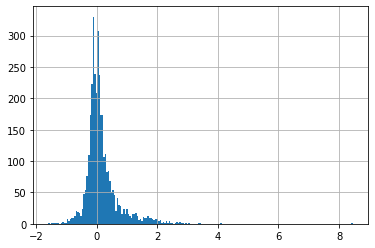

In [35]:
specialised_skill_trends[0].Slope.hist(bins=200)

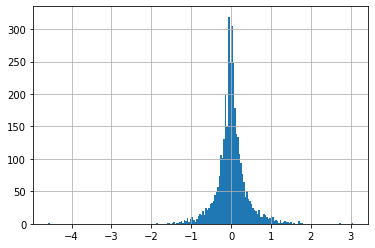

In [36]:
specialised_skill_trends[1].Slope.hist(bins=200)

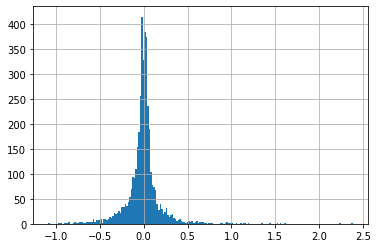

In [37]:
specialised_skill_trends[2].Slope.hist(bins=200)

In [41]:
specialised_skill_trends[0].loc[specialised_skill_trends[0].Slope >= specialised_skill_trends[0].Slope.mean() + 
                             specialised_skill_trends[0].Slope.std()]

,Slope,Intercept,Acceleration,Spikiness,Job Postings Raw
Skill,,,,,
.NET,0.992229,105.956945,216.210407,2.175408,9161
AJAX,1.269027,78.097940,211.021594,2.501387,2818
API Management,2.179102,22.458107,118.087123,3.280725,928
ASP.NET,1.513084,77.759461,251.437842,2.235552,4293
ASP.NET MVC,1.407182,37.648418,119.922441,2.738591,1110
...,...,...,...,...,...
Web Site Design,1.931688,49.513937,232.810479,2.764877,1934
Wide Area Network (WAN),0.786898,78.508558,130.556795,2.212336,4315
Windows Server,1.925023,73.865208,318.555964,2.505009,4687


In [42]:
specialised_skill_trends[0].Slope.mean() + specialised_skill_trends[0].Slope.std()

0.7174520211775959

In [252]:
specialised_skill_trends[0].Slope.mean() + 3 * specialised_skill_trends[0].Slope.std()

1.827112060822452

In [46]:
specialised_skill_trends[0].Slope.quantile(0.90)

0.7737881504504787

In [76]:
from scipy.stats import shapiro, anderson, probplot
from scipy import stats

In [225]:
anderson(specialised_skill_trends[0].Slope.values, dist='norm')

AndersonResult(statistic=185.9473032996366, critical_values=array([0.575, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [288]:
def normalise_list(l, remove_thresh=2):
    l = np.array([x for x in l if abs(x) < remove_thresh])
    return l

((array([-7.998998  , -7.11220876, -6.64574035, ...,  6.64574035,
          7.11220876,  7.998998  ]),
  array([-1.08509714, -0.9693574 , -0.96021708, ...,  1.5224305 ,
          1.55028194,  1.60377516])),
 (0.13058690768656464, -0.007846230226767212, 0.9691176895524218))

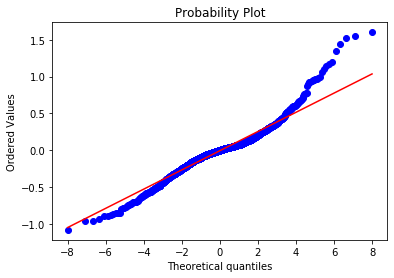

In [289]:
probplot(normalise_list(specialised_skill_trends[2].Slope.values), dist=stats.laplace, 
         sparams=(), fit=True, plot=plt)

((array([-7.83825914, -6.95147068, -6.48500226, ...,  6.48500226,
          6.95147068,  7.83825914]),
  array([-1.59005225, -1.54081844, -1.48729634, ...,  1.98502453,
          1.98509931,  1.98794003])),
 (0.31781985479097297, 0.128614178510036, 0.961677827882973))

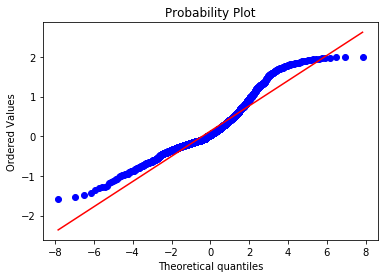

In [290]:
probplot(normalise_list(specialised_skill_trends[0].Slope.values), dist=stats.laplace, 
         sparams=(), fit=True, plot=plt)

((array([-7.85881255, -6.97202398, -6.50555557, ...,  6.50555557,
          6.97202398,  7.85881255]),
  array([-1.85883118, -1.85837776, -1.59774471, ...,  1.73353807,
          1.77987776,  1.78869642])),
 (0.2685434669043494, 0.010779332393429819, 0.9950299823006169))

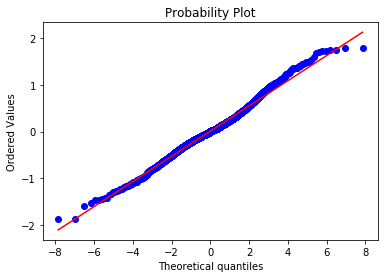

In [291]:
probplot(normalise_list(specialised_skill_trends[1].Slope.values), dist=stats.laplace, 
         sparams=(), fit=True, plot=plt)

((array([-0.24225379, -0.21197144, -0.19487864, ...,  3.36850546,
          3.49501875,  3.72503429]),
  array([-3.43399237, -3.33674848, -3.23103462, ...,  4.50077507,
          4.56101301,  4.63501019])),
 (1.5863597164359822, -1.2592416973087588, 0.9635928138732414))

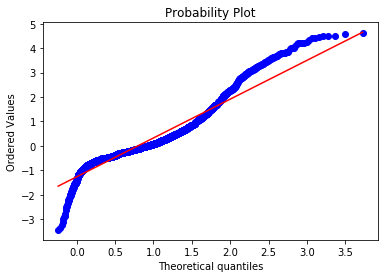

In [277]:
probplot(normalise_list(specialised_skill_trends[0].Slope.values), dist=stats.skewnorm, 
         sparams=(10), fit=True, plot=plt)

((array([-0.24261103, -0.21236145, -0.1952895 , ...,  3.37151674,
          3.49793437,  3.72779007]),
  array([-4.91318068, -4.91198915, -4.22706721, ...,  4.52726646,
          4.6490433 ,  4.672218  ])),
 (1.545816095697604, -1.2270604930229143, 0.9389744449135157))

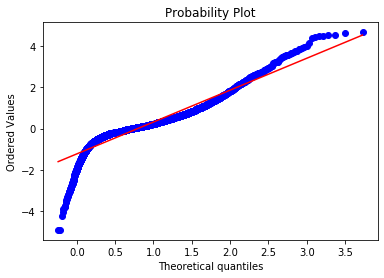

In [278]:
probplot(normalise_list(specialised_skill_trends[1].Slope.values), dist=stats.skewnorm, 
         sparams=(10), fit=True, plot=plt)

((array([-43.96137592, -37.01508699, -33.53690858, ...,  33.53690858,
          37.01508699,  43.96137592]),
  array([-1.08509714, -0.9693574 , -0.96021708, ...,  1.5224305 ,
          1.55028194,  1.60377516])),
 (0.03691439859749248, -0.007846230226767222, 0.9931946274924092))

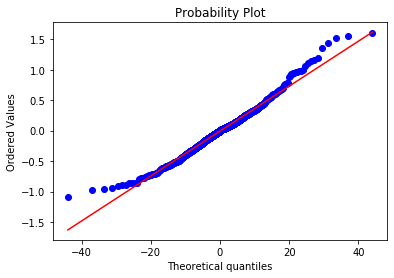

In [358]:
probplot(normalise_list(specialised_skill_trends[2].Slope.values), dist=stats.gennorm, 
         sparams=(0.6), fit=True, plot=plt)

((array([-7.85881255, -6.97202398, -6.50555557, ...,  6.50555557,
          6.97202398,  7.85881255]),
  array([-1.85883118, -1.85837776, -1.59774471, ...,  1.73353807,
          1.77987776,  1.78869642])),
 (0.26854346690434927, 0.010779332393429836, 0.9950299823006166))

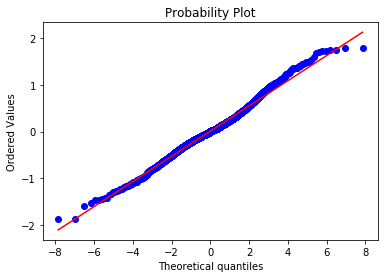

In [296]:
probplot(normalise_list(specialised_skill_trends[1].Slope.values), dist=stats.gennorm, 
         sparams=(1), fit=True, plot=plt)

((array([-3.60730796, -3.30316997, -3.13818318, ...,  3.13818318,
          3.30316997,  3.60730796]),
  array([-1.59005225, -1.54081844, -1.48729634, ...,  1.98502453,
          1.98509931,  1.98794003])),
 (0.5178061954996652, 0.12861417851003606, 0.9536144205681003))

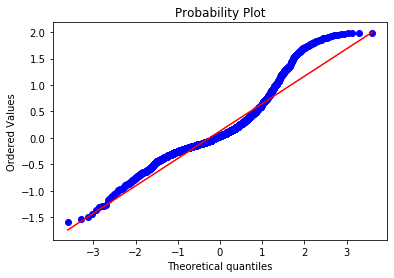

In [317]:
probplot(normalise_list(specialised_skill_trends[0].Slope.values), dist=stats.gennorm, 
         sparams=(1.5), fit=True, plot=plt)

((array([1.29602605e-02, 2.01943387e-02, 2.55020212e-02, ...,
         3.92125781e+01, 4.95188289e+01, 7.71589428e+01]),
  array([    1,     1,     1, ..., 38984, 39538, 45870])),
 (1016.1329102430302, -826.7016770330932, 0.9432407028905391))

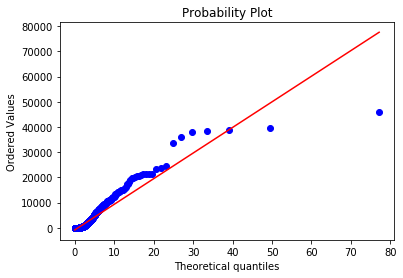

In [399]:
probplot(normalise_list(skills_df[['Skill', 'Job Postings Raw']].groupby('Skill').sum()['Job Postings Raw'].values,
                       remove_thresh=50000), 
         dist=stats.fisk, 
         sparams=(2), fit=True, plot=plt)